In [1]:
# read states from pkl files
import pickle
import numpy as np

# load states from several seeds
seedResStatesOriginal = []
seedResStatesShifted = []
original_seed_dir = 'data/resStatesOriginal/'
shifted_seed_dir = 'data/resStatesShifted/'

# collect all pkl files in each dir
import os
original_seed_files = os.listdir(original_seed_dir)
shifted_seed_files = os.listdir(shifted_seed_dir)

for file in original_seed_files:
    seedResStatesOriginal.append(pickle.load(open(original_seed_dir + file, 'rb')))

for file in shifted_seed_files:
    seedResStatesShifted.append(pickle.load(open(shifted_seed_dir + file, 'rb')))

In [2]:
# now calculate time constant (time for state to hit 1/2 of its max/initial value)
# begin/end reger to subset of states that has the different-to-same shift

all_timeconstants = []

for seed in range(len(seedResStatesOriginal)):

    statesOriginal = seedResStatesOriginal[seed]
    statesShifted = seedResStatesShifted[seed]
    
    timeconstants_per_network = {network: None for network in statesOriginal}

    for network in statesOriginal:
        # resn = numNode
        # index = 0
        begin=433
        end=683
        data = statesOriginal[network][begin:end,:] - statesShifted[network][begin:end,:]
        # print(data.shape)
        dataT=data.T

        timeconstants = np.zeros(dataT.shape[0])
        res_maxes = np.zeros(dataT.shape[0])

        #calculate the alignment time:  dataT(neurons,time)
        #interate over reservoir neuron
        for neuron in range(dataT.shape[0]):
            # get the value
            max = abs(dataT[neuron,0])
            if max > -1:  #WAS 0.05
                for timestep in range(dataT.shape[1]):
                    if abs(dataT[neuron,timestep]) < max/2:
                        timeconstants[neuron] = timestep
                        res_maxes[neuron] = max
                        max=-1     
                        
        save_timeconstants = timeconstants
        # timeconstants = np.sort(save_timeconstants)

        timeconstants_per_network[network] = save_timeconstants

    all_timeconstants.append(timeconstants_per_network)

In [3]:
# now calculate the average time constant for each network across all seeds

average_timeconstants = {network: None for network in statesOriginal}

for network in statesOriginal:

    timeconstants = np.zeros(len(all_timeconstants[0][network]))

    for seed in range(len(all_timeconstants)):
        timeconstants += all_timeconstants[seed][network]

    timeconstants /= len(all_timeconstants)

    average_timeconstants[network] = timeconstants

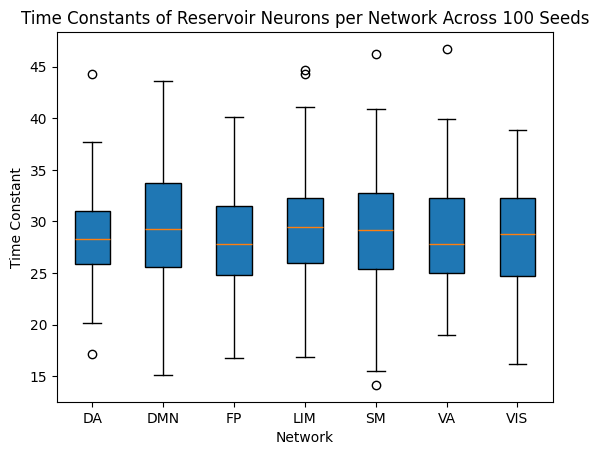

In [7]:
# now we can plot them as multiple boxplots

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.boxplot([average_timeconstants[network] for network in statesOriginal if network != 'Baseline'], patch_artist=True, vert=True)

ax.set_xticklabels(list(statesOriginal.keys())[:-1])
ax.set_ylabel('Time Constant')
ax.set_xlabel('Network')
# ax.set_ylim(0,40)
plt.title('Time Constants of Reservoir Neurons per Network Across {} Seeds'.format(len(seedResStatesOriginal)))
plt.show()